# Treinamento e validação de Modelos - Dataset Combinado
Treinamento de um modelo usando como base um dataset combinado, constituído dos dois datasets utilizados ao longo do projeto: 
- Fake.br-Corpus: https://github.com/roneysco/Fake.br-Corpus
- FakeRecogna: https://github.com/Gabriel-Lino-Garcia/FakeRecogna 

Espera-se que um modelo treinado a partir de ambos datasets possua um desempenho melhor em uma maior variedade de notícias.

In [1]:
# Se necessário
%pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 435 kB 33.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sagemaker
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score
from python_scripts.save_load import load_df_from_bucket, save_df_to_s3_bucket, save_to_s3_bucket_as_libsvm, save_to_s3_bucket_as_recordio, BUCKET_MODEL
from python_scripts.modelling import create_train_validation_test_sets, setup_model, make_prediction, load_batch_results
from python_scripts.plots import plot_confusion_matrix

Matplotlib is building the font cache; this may take a moment.


## Carregamento de dados
O dataset combinado já foi criado e salvo no notebook `preprocessing.ipynb`. Aqui, ele é apenas carregado novamente a partir do S3.

In [4]:
model_df = load_df_from_bucket('dados_processados_combinados.csv', tipo='processado')
model_df.head()

,fake,lemmas_str
0,0,divisão STF meio partidário independente ficar...
1,1,general mandar recado STF abaixar calça congre...
2,1,nordeste acordar Lula PT enxotar chegar bandei...
3,0,dois relatório Polícia Federal análise materia...
4,1,Coreia Norte declarar status QUASE-GUERRA mobi...


## Modelo 1: TF-IDF e XGBoost baseado no texto da notícia
Vetorização TF-IDF é aplicada somente à coluna de texto da notícia. Demais colunas de dados não são consideradas.

In [33]:
# Tamanhos de teste e validação garantem que o arquivo de teste seja < 5 MB, facilita implementação
train_1, test_1, validate_1 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.1, random_state=42,
                                                                validation_size=0.55)

### Processamento adicional

Um vetorizador TFIDF é utilizado para converter os dados textuais em colunas do DataFrame.

In [34]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_1['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [35]:
def create_x_y_1(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res, base_df[target_col]

x_train_1, y_train_1 = create_x_y_1(train_1, tfidf)
x_validate_1, y_validate_1 = create_x_y_1(validate_1, tfidf)
x_test_1, y_test_1 = create_x_y_1(test_1, tfidf)

### Upload de dados para o S3

In [7]:
file_name_tuples = [(x_train_1, y_train_1, 'train'), 
                   (x_test_1, y_test_1, 'test'), 
                   (x_validate_1, y_validate_1, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_1_combo.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Treinar modelo

In [8]:
xgb_model_1, data_channels_1 = setup_model(base_image='xgboost', model_name='model_1_combo', instance_count=4, 
                                           instance_type='ml.m4.xlarge')
xgb_model_1.fit(inputs=data_channels_1)

print('ready for hosting!')

2022-11-15 22:21:57 Starting - Starting the training job...ProfilerReport-1668550916: InProgress
...
2022-11-15 22:22:48 Starting - Preparing the instances for training............
2022-11-15 22:24:48 Downloading - Downloading input data...
2022-11-15 22:25:25 Training - Downloading the training image......
2022-11-15 22:26:16 Training - Training image download completed. Training in progress.[2022-11-15 22:26:20.549 ip-10-0-66-226.ec2.internal:8 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-15:22:26:20:INFO] Imported framework sagemaker_xgboost_container.training
[2022-11-15:22:26:20:INFO] Failed to parse hyperparameter eval_metric value map to Json.
Returning the value itself
[2022-11-15:22:26:20:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-11-15:22:26:20:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-15:22:26:20:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-11-15:22:26:20:INFO

In [9]:
xgb_predictor_1 = xgb_model_1.deploy(initial_instance_count=1,
                                     serializer=sagemaker.serializers.LibSVMSerializer(),
                                     instance_type='ml.m4.xlarge')

----------!

### Métricas do modelo

In [39]:
y_pred_1 = make_prediction(xgb_predictor_1, model_name='model_1_combo')

# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_1 = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_1_combo.csv')

In [11]:
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       430
           1       0.88      0.94      0.91       429

    accuracy                           0.91       859
   macro avg       0.91      0.91      0.91       859
weighted avg       0.91      0.91      0.91       859



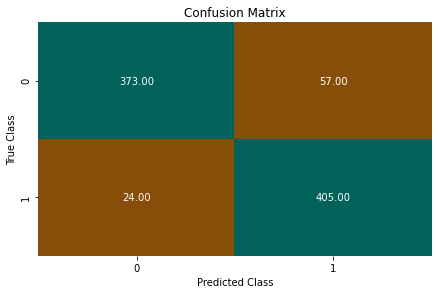

In [41]:
plot_confusion_matrix(y_test_1, y_pred_1)

In [42]:
precision_score(y_test_1, y_pred_1)

0.8766233766233766

Verifica-se um excelente desempenho do modelo baseado no dataset combinado, com 87.7% de precisão. Todavia, como foi visto no notebook `model_fakebr.ipynb`, é necessário ter cautela ao extrapolar os resultados para verificação de notícias fora dos datasets estudados. Idealmente, o modelo seria aprimorado ao longo do tempo com cada vez mais textos de notícias, a fim de garantir sua precisão na detecção de notícias falsas.

Mais adiante neste mesmo notebook, um job de otimização de hiperparâmetros será executado para verificar a possibilidade de aprimorar aindam ais este modelo.

### Salvar predição

In [12]:
df_pred_alt = pd.DataFrame({'pred_1_combo': y_pred_1})
df_pred_alt.to_csv(f's3://{BUCKET_MODEL}/test/pred_1_combo.csv', encoding='utf-8', index=False)

### Encerrar modelo

In [13]:
xgb_predictor_1.delete_endpoint(delete_endpoint_config=True) 

## Modelo 2: Otimização de Hiperparâmetros
Este modelo é treinado analogamente ao primeiro modelo, porém aplicando otimização de hiperparâmetros para tentar otimizar o modelo.

In [4]:
# Tamanhos de teste e validação garantem que o arquivo de teste seja < 5 MB, facilita implementação
train_2, test_2, validate_2 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.1, random_state=42,
                                                                validation_size=0.55)

### Processamento adicional

Mesmo processamento feito para o modelo 1.

In [5]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_2['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [6]:
def create_x_y_2(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res, base_df[target_col]

x_train_2, y_train_2 = create_x_y_2(train_2, tfidf)
x_validate_2, y_validate_2 = create_x_y_2(validate_2, tfidf)
x_test_2, y_test_2 = create_x_y_2(test_2, tfidf)

### Upload para o S3

In [7]:
file_name_tuples = [(x_train_2, y_train_2, 'train'), 
                   (x_test_2, y_test_2, 'test'), 
                   (x_validate_2, y_validate_2, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_2_combo.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Preparar modelo e job de otimização

In [10]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
xgb_model_2, data_channels_2 = setup_model(base_image='xgboost', model_name='model_1_combo', instance_count=4, 
                                           instance_type='ml.m4.xlarge')

# Poucos hiperparâmetros para não estourar limite de 4h por sessão!
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'eta': ContinuousParameter(0.1, 0.5),  
                         'num_round': IntegerParameter(1,50),
                         'max_depth': IntegerParameter(0,10),
                         'subsample': ContinuousParameter(0.5 ,1.0)
                         }

objective_metric_name = 'validation:map'
objective_type = 'Maximize'

tuner = HyperparameterTuner(xgb_model_2,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=5,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

### Treinamento com otimização

In [11]:
tuner.fit(inputs=data_channels_2, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [12]:
import boto3
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

#### Verificar os 10 melhores modelos

In [13]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(10)

,alpha,eta,max_depth,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
19,24.366929,0.498098,8.0,47.0,0.828344,sagemaker-xgboost-221116-1432-001-f76a0652,Completed,0.97906,2022-11-16 14:34:44+00:00,2022-11-16 15:27:44+00:00,3180.0
5,18.429791,0.496115,6.0,45.0,0.933908,sagemaker-xgboost-221116-1432-015-d82f4793,Completed,0.97738,2022-11-16 14:47:40+00:00,2022-11-16 15:20:03+00:00,1943.0
9,0.000000,0.457902,7.0,42.0,0.623636,sagemaker-xgboost-221116-1432-011-db98ee47,Completed,0.97642,2022-11-16 14:43:02+00:00,2022-11-16 15:22:28+00:00,2366.0
0,54.509962,0.395291,6.0,25.0,0.841019,sagemaker-xgboost-221116-1432-020-5ab55913,Completed,0.96938,2022-11-16 15:15:20+00:00,2022-11-16 15:33:01+00:00,1061.0
6,44.972727,0.469102,6.0,33.0,0.500000,sagemaker-xgboost-221116-1432-014-f8fa9545,Completed,0.96811,2022-11-16 14:45:52+00:00,2022-11-16 15:05:19+00:00,1167.0
2,85.472478,0.427509,6.0,42.0,0.546797,sagemaker-xgboost-221116-1432-018-f7f505ff,Completed,0.96362,2022-11-16 15:08:53+00:00,2022-11-16 15:33:34+00:00,1481.0
4,77.459432,0.363413,6.0,26.0,1.000000,sagemaker-xgboost-221116-1432-016-0cebd355,Completed,0.96352,2022-11-16 14:49:14+00:00,2022-11-16 15:08:36+00:00,1162.0
17,72.018104,0.340833,6.0,14.0,0.969709,sagemaker-xgboost-221116-1432-003-589e8686,Completed,0.95252,2022-11-16 14:35:04+00:00,2022-11-16 14:48:53+00:00,829.0
3,39.770417,0.471348,5.0,5.0,0.696355,sagemaker-xgboost-221116-1432-017-6b00ab86,Completed,0.90743,2022-11-16 15:06:46+00:00,2022-11-16 15:10:30+00:00,224.0
1,58.644949,0.428529,6.0,3.0,0.528380,sagemaker-xgboost-221116-1432-019-c86e0753,Completed,0.86601,2022-11-16 15:10:59+00:00,2022-11-16 15:14:27+00:00,208.0


### Criar modelo com melhor training job e fazer predição

In [14]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [15]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model()


2022-11-16 15:27:47 Starting - Preparing the instances for training
2022-11-16 15:27:47 Downloading - Downloading input data
2022-11-16 15:27:47 Training - Training image download completed. Training in progress.
2022-11-16 15:27:47 Uploading - Uploading generated training model
2022-11-16 15:27:47 Completed - Resource retained for reuse


In [16]:
xgb_predictor_2 = best_algo_model.deploy(initial_instance_count=1,
                                     serializer=sagemaker.serializers.LibSVMSerializer(),
                                     instance_type='ml.m4.xlarge')

-------!

In [17]:
y_pred_2 = make_prediction(xgb_predictor_2, model_name='model_2_combo')

### Métricas do modelo

In [18]:
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       430
           1       0.91      0.94      0.93       429

    accuracy                           0.93       859
   macro avg       0.93      0.93      0.93       859
weighted avg       0.93      0.93      0.93       859



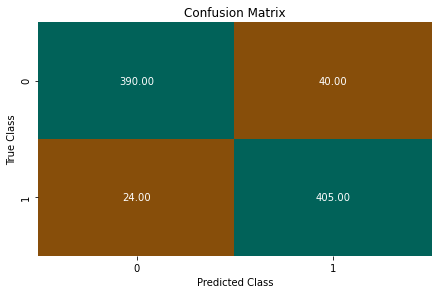

In [19]:
plot_confusion_matrix(y_test_2, y_pred_2)

In [20]:
precision_score(y_test_2, y_pred_2)

0.9101123595505618

O modelo otimizado apresentou uma melhora comparado ao modelo original; a nova precisão obtida é de 91.0%, comparada à precisão de 87.7% do primeiro modelo treinado neste notebook. O recall dos dois modelos é equivalente, enquanto que o F1-score apresentou ligeira melhora com a otimização de hiperparâmetros, sendo levado de 91% no primeiro modelo para 93% no segundo. Uma exploração de maior gama de possíveis hiperparâmetros eventualmente poderia resultar em uma melhora mais significativa do modelo.

### Encerrar modelo

In [21]:
xgb_predictor_2.delete_endpoint(delete_endpoint_config=True)

## Modelo 3: LinearLearner com otimização de Hiperparâmetros
A vetorização TF-IDF será aplicada de forma semelhante aos dois modelos anteriores. Porém, o algoritmo de treinamento aplicado será baseado em um modelo linear, em vez de um XGBoost como feito anteriormente.

O modelo linear foi escolhido como um baseline de modelo simples, para comparação com os resultados obtidos com o modelo XGBoost.

In [4]:
train_3, test_3, validate_3 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.2, random_state=42,
                                                                validation_size=0.5)

In [5]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_3['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [6]:
def create_x_y_3(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    """
    Necessário usar array de float32 neste modelo! Tanto para dados como labels.
    Tbm necessário resetar index dos labels para funcionar corretamente
    """
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res.astype(np.float32), base_df[target_col].reset_index(drop=True).astype(np.float32)

x_train_3, y_train_3 = create_x_y_3(train_3, tfidf)
x_validate_3, y_validate_3 = create_x_y_3(validate_3, tfidf)
x_test_3, y_test_3 = create_x_y_3(test_3, tfidf)

### Upload para o S3

In [7]:
file_name_tuples = [(x_train_3, y_train_3, 'train'), 
                   (x_test_3, y_test_3, 'test'), 
                   (x_validate_3, y_validate_3, 'validate')]

for x, y, prefix in file_name_tuples:
#     linear model usa protobuf
    save_to_s3_bucket_as_recordio(x, y, prefix=prefix, filename='model_3_combo.protobuf', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


### Preparar o modelo
Como o modelo LinearLearner será utilizado apenas aqui em todo o projeto, o seu setup será desenvolvido explicitamente na célula a seguir

In [8]:
import boto3
from python_scripts.save_load import BUCKET_MODEL

model_name = 'model_3_combo'

container = sagemaker.image_uris.retrieve('linear-learner',boto3.Session().region_name)

hyperparams = {'predictor_type': "binary_classifier"}
s3_output_location=f"s3://{BUCKET_MODEL}/output/{model_name}"

linear_model=sagemaker.estimator.Estimator(container,
                                        sagemaker.get_execution_role(),
                                        instance_count=4,
                                        instance_type='ml.m4.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/{}".format(BUCKET_MODEL,'train',f'{model_name}.protobuf'))

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/{}".format(BUCKET_MODEL,'validate',f'{model_name}.protobuf'))

data_channels_3 = {'train': train_channel, 'validation': validate_channel}

### Preparar job de otimização

In [11]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
# Poucos hiperparâmetros para não estourar limite de 4h por sessão!
hyperparameter_ranges = {"wd": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
                         "learning_rate": ContinuousParameter(1e-5, 1, scaling_type="Auto"),
                         "mini_batch_size": IntegerParameter(100, 2000, scaling_type="Auto"),
                         "l1": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
                         "use_bias": CategoricalParameter([True, False])
                         }

objective_metric_name = 'validation:precision'
objective_type = 'Maximize'

tuner_3 = HyperparameterTuner(linear_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=5,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

### Treinamento com otimização

In [12]:
tuner_3.fit(inputs=data_channels_3, include_cls_metadata=False)
tuner_3.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Criar modelo com melhor training job e fazer predição

In [13]:
attached_tuner_3 = HyperparameterTuner.attach(tuner_3.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job_3 = attached_tuner_3.best_training_job()

In [14]:
from sagemaker.estimator import Estimator
algo_estimator_3 = Estimator.attach(best_training_job_3)

best_algo_model_3 = algo_estimator_3.create_model()


2022-11-16 22:49:05 Starting - Preparing the instances for training
2022-11-16 22:49:05 Downloading - Downloading input data
2022-11-16 22:49:05 Training - Training image download completed. Training in progress.
2022-11-16 22:49:05 Uploading - Uploading generated training model
2022-11-16 22:49:05 Completed - Resource released due to keep alive period expiry


#### Predição via batches

In [15]:
batch_X_file='model_3_combo.protobuf'
bucket = BUCKET_MODEL
prefix = 'test'

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/{}".format(bucket,prefix,batch_X_file)

lin_transformer = best_algo_model_3.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

lin_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='application/x-recordio-protobuf',
                         split_type='RecordIO'
                         )
lin_transformer.wait()

..........................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/17/2022 00:46:27 INFO 139672031606592] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[11/17/2022 00:46:31 WARNING 139672031606592] Loggers have already been setup.
[11/17/2022 00:46:31 INFO 139672031606592] loaded entry point class algorithm.serve.server_config:config_api
[11/17/2022 00:46:31 INFO 139672031606592] loading entry points
[11/17/2022 00:46:31 INFO 139672031606592] loaded request iterator application/json
[11/17/2022 00:46:31 INFO 139672031606592] loaded request iterator application/jsonlines
[11/17/2022 00:46:31 INFO 139672031606592] loaded request iterator application/x-recordio-protobuf
[11/17/2022 00:46:31 INFO 139672031606592] loaded request iterator text/csv
[11/17/2022 00:46:31 INFO 139672031606592] loaded response encoder application/json
[11/17/2022 00:46:31 INFO 139672031606592] loaded respons

In [23]:
df_pred_3 = load_batch_results('model_3_combo')

In [24]:
y_pred_3 = df_pred_3['predicted_label']

### Métricas do modelo

In [25]:
print(classification_report(y_test_3, y_pred_3))

              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       955
         1.0       0.88      0.76      0.82       955

    accuracy                           0.83      1910
   macro avg       0.83      0.83      0.83      1910
weighted avg       0.83      0.83      0.83      1910



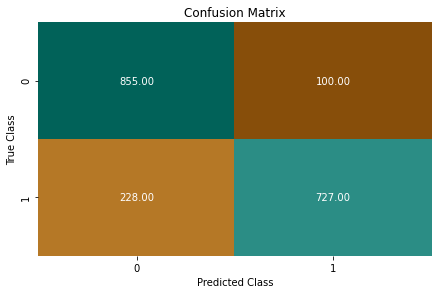

In [26]:
plot_confusion_matrix(y_test_3, y_pred_3)

In [27]:
precision_score(y_test_3, y_pred_3)

0.879081015719468

## Modelo 4: Factorization Machine com otimização de Hiperparâmetros
A vetorização TF-IDF será aplicada de forma semelhante aos dois modelos anteriores. Porém, o algoritmo de treinamento aplicado será baseado em um modelo Factorization Machine diferente dos modelos utilizados anteriormente.

O modelo de Factorization Machines é uma extensão do modelo linear adaptado para datasets esparsos (https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines.html), propriedade útil ao presente rpoblema.

In [5]:
train_4, test_4, validate_4 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.2, random_state=42,
                                                                validation_size=0.5)

In [6]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_4['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [7]:
def create_x_y_4(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    """
    Necessário usar array de float32 neste modelo! Tanto para dados como labels.
    Tbm necessário resetar index dos labels para funcionar corretamente
    """
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res.astype(np.float32), base_df[target_col].reset_index(drop=True).astype(np.float32)

x_train_4, y_train_4 = create_x_y_4(train_4, tfidf)
x_validate_4, y_validate_4 = create_x_y_4(validate_4, tfidf)
x_test_4, y_test_4 = create_x_y_4(test_4, tfidf)

### Upload para o S3

In [8]:
file_name_tuples = [(x_train_4, y_train_4, 'train'), 
                   (x_test_4, y_test_4, 'test'), 
                   (x_validate_4, y_validate_4, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_recordio(x, y, prefix=prefix, filename='model_4_combo.protobuf', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


### Preparar o modelo

In [33]:
import boto3
from python_scripts.save_load import BUCKET_MODEL

model_name = 'model_4_combo'

container = sagemaker.image_uris.retrieve("factorization-machines",boto3.Session().region_name)

hyperparams = {'feature_dim': f"{x_train_4.shape[1]}",
               'predictor_type': 'binary_classifier',
               'mini_batch_size': '200',
               'num_factors': '10'}
s3_output_location=f"s3://{BUCKET_MODEL}/output/{model_name}"

fm_model=sagemaker.estimator.Estimator(container,
                                        sagemaker.get_execution_role(),
                                        instance_count=4,
                                        instance_type='ml.m5.xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/{}".format(BUCKET_MODEL,'train',f'{model_name}.protobuf'))

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/{}".format(BUCKET_MODEL,'validate',f'{model_name}.protobuf'))

data_channels_4 = {'train': train_channel, 'test': validate_channel}

### Preparar job de otimização

In [34]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {"mini_batch_size": IntegerParameter(100, 10000, scaling_type="Auto"),
                         "epochs": IntegerParameter(1, 1000, scaling_type="Auto"),
                         "linear_lr": ContinuousParameter(1e-8, 512, scaling_type='Auto'),
                         "linear_wd": ContinuousParameter(1e-8, 512, scaling_type='Auto'),
                         }

objective_metric_name = 'test:binary_classification_accuracy'
objective_type = 'Maximize'

tuner_4 = HyperparameterTuner(fm_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=5,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

### Treinamento com otimização

In [35]:
tuner_4.fit(inputs=data_channels_4, include_cls_metadata=False)
tuner_4.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Criar modelo com melhor training job e fazer predição

In [36]:
attached_tuner_4 = HyperparameterTuner.attach(tuner_4.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job_4 = attached_tuner_4.best_training_job()

In [37]:
from sagemaker.estimator import Estimator
algo_estimator_4 = Estimator.attach(best_training_job_4)

best_algo_model_4 = algo_estimator_4.create_model()


2022-11-17 04:32:55 Starting - Found matching resource for reuse
2022-11-17 04:32:55 Downloading - Downloading input data
2022-11-17 04:32:55 Training - Training image download completed. Training in progress.
2022-11-17 04:32:55 Uploading - Uploading generated training model
2022-11-17 04:32:55 Completed - Resource reused by training job: factorization-machin-221117-0357-016-a928a735


#### Predição via batches

In [38]:
batch_X_file='model_4_combo.protobuf'
bucket = BUCKET_MODEL
prefix = 'test'

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/{}".format(bucket,prefix,batch_X_file)

fm_transformer = best_algo_model_4.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

fm_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='application/x-recordio-protobuf',
                         split_type='RecordIO'
                         )
fm_transformer.wait()

...............................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/17/2022 06:46:27 INFO 140692244002624] loaded entry point class algorithm.serve.server_config:config_api
[11/17/2022 06:46:27 INFO 140692244002624] loading entry points
[11/17/2022 06:46:27 INFO 140692244002624] loaded request iterator application/json
[11/17/2022 06:46:27 INFO 140692244002624] loaded request iterator application/jsonlines
[11/17/2022 06:46:27 INFO 140692244002624] loaded request iterator application/x-recordio-protobuf
[11/17/2022 06:46:27 INFO 140692244002624] loaded response encoder application/json
[11/17/2022 06:46:27 INFO 140692244002624] loaded response encoder application/jsonlines
[11/17/2022 06:46:27 INFO 140692244002624] loaded response encoder application/x-recordio-protobuf
[11/17/2022 06:46:27 INFO 14069224400262

In [39]:
df_pred_4 = load_batch_results('model_4_combo')

In [40]:
y_pred_4 = df_pred_4['predicted_label']

### Métricas do modelo

In [41]:
print(classification_report(y_test_4, y_pred_4))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       955
         1.0       0.93      0.91      0.92       955

    accuracy                           0.92      1910
   macro avg       0.92      0.92      0.92      1910
weighted avg       0.92      0.92      0.92      1910



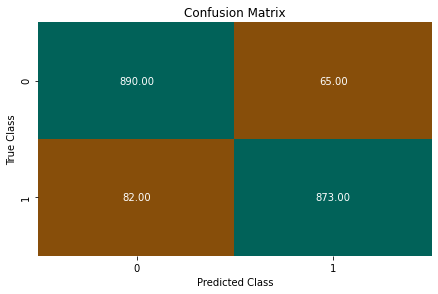

In [42]:
plot_confusion_matrix(y_test_4, y_pred_4)

In [43]:
precision_score(y_test_4, y_pred_4)

0.9307036247334755

O modelo treinado com Factorization Machine também apresentou um excelente desempenho. Obteve-se um valor de 93% para a métrice de interesse, precisão, enquanto que recall e F1-score também se mantiveram acima de 90%.

## Conclusões

Um total de quatro modelos foram treinados com o dataset combinado: dois modelos XGBoost, um sem otimização de hiperparâmetros e outro com otimização, um modelo Linear Learner e um modelo de Factorization Machines, sendo que estes dois últimos também empregaram a otimização de hiperparâmetros.

Destes, o modelo XGBoost e o modelo de Factorization Machines se destacaram na métrica de interesse do projeto, precisão, sendo encontrados valores de 91% para a precisão do XGBoost e 93% para precisão da Factorization Machine. O modelo Linear Learner apresentou desempenho inferior aos demais, como é de se esperar por sua maior simplicidade.

Uma vez que uma notícia falsa foi considerada como classe positiva na análise, priorizou-se a precisão do modelo, de forma a identificar o máximo de notícias falsas possíveis. Desta forma, recomenda-se a utilização do modelo de Factorization Machines, dentre os modelos estudados durante o projeto. Todavia, o modelo XGBoost também apresentou um bom desempenho nesta métrica e também apresentou valores maiores de recall e F1-score. Caso deseje-se evitar classificação errônea de notícias reais, este modelo pode ser utilizado.

